In [46]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots,CSV,DataFrames;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:

#https://github.com/fkguo/IMinuit.jl/blob/master/src/Data.jl
# check whether the data are valid for a fit
function check_data(xdata, ydata, errdata)
    if any(ismissing, xdata) || any(ismissing, ydata) || any(ismissing, errdata)
        error("Error: Data contain `missing` values.")
    end
    if any(isinf, xdata) || any(isinf, ydata) || any(isnan, xdata) || any(isnan, ydata) || any(isnan, errdata)
        error("Error: Data contain `Inf` or `NaN` values.")
    end
    if any(iszero, errdata)
        error("Error: Data contain 0 in the errors.")
    end
end

"""
    Data(x::T, y::T, err::T) where {T<:Vector{Real}}
    Data(df::DataFrame)
Fields: `x, y, err, ndata`
This defines a type for data with three columns:` x, y, err`; `ndata` is the number of data rows.
Different `Data` sets can be concatenated as `vcat(dat1, dat2, dat3)`.
Only symmetric errors (of `y`) are supported.
"""
struct Data
    x::Vector{Float64}
    y::Vector{Float64}
    err::Vector{Float64}
    ndata::Int
    function Data(x, y, err) # Data(x::Vector{T}, y::Vector{T}, err::Vector{T}) where {T<:Real}
        check_data(x, y, err)
        ndata = length(x)
        new(x, y, err, ndata)
    end
end

Data(df::DataFrame) = Data(df[:,1], df[:,2], df[:,3])

import Base.vcat, Base.getindex
vcat(dat1::Data, dat2::Data) = Data(vcat(dat1.x, dat2.x), vcat(dat1.y, dat2.y), vcat(dat1.err, dat2.err))
vcat(dat1::Data, dat...) = reduce(vcat, [dat1, dat...])
getindex(data::Data, in) = Data(map(x-> getindex(x, in), (data.x, data.y, data.err))...)

"""
    @plt_data(data, kws...)
    @plt_data!(data, kws...)
Convenient mascros to make an errorbar plot of the `data`; all combinations of
keyword settings for `scatter` in `Plots` can be used for the optional arguments `kws...`
"""
macro plt_data(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end
macro plt_data!(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter!($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter!($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end

@doc raw"""
    chisq(dist::Function, data, par; fitrange = ())
defines the ``\chi^2`` function: `fun` the function to be fitted to the data given by `data`.
The parameters are collected into `par`, given as an array or a tuple.
* `data` can be either given as the `Data` type, or of the form `(xdata, ydata [, err])`.
If no `err` is given explicitly, the errors are assumed to be 1 for all data points.
* `fitrange`: default to the whole data set; may given as, e.g., `2:10`,
which means only fitting to the 2nd to the 10th data points.
"""
function chisq(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
    end
    return res
end
# function chisq(dist::Function, data::Data, par::Tuple; fitrange = ())
#     fitrange = (isempty(fitrange) && 1:data.ndata)
#     res = 0.0
#     @simd for i = fitrange
#         @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
#     end
#     return res
# end
function chisq(dist::Function, data, par; fitrange = ())
    _x = data[1]; _y = data[2]
    _n = length(_x)
    _err = (length(data) == 2 ? ones(_n) : data[3])
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (_y[i]- dist(_x[i], par))/_err[i] )^2
    end
    return res
end

"""
    @plt_best(dist, fit, data, kws...)
    @plt_best!(dist, fit, data, kws...)
A convenient macro for comparing the best-fit result with the data; all combinations of
keyword settings for `plot` in `Plots` can be used for the optional arguments `kws...`
The ordering of `dist`, `fit`, and `data` does not matter.
"""
macro plt_best(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

macro plt_best!(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter!($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

quadgauss (generic function with 1 method)

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+2*length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [7]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))

dΓsmc (generic function with 1 method)

In [8]:
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [9]:
function getqw(E,Λ;ω=0.1,V0=-0.1,qi=qi,wi=wi)
    pmax=sqrt(abs(λf(E^2,mDn^2,(mπc+mDn)^2)))/(2*E)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    for i in eachindex(xxx)
        qi[2+i]=pmax*xxx[i]
        qi[2+len+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [10]:
getqw(mDn+mDsc-360e-6-im*24e-6,0.6)

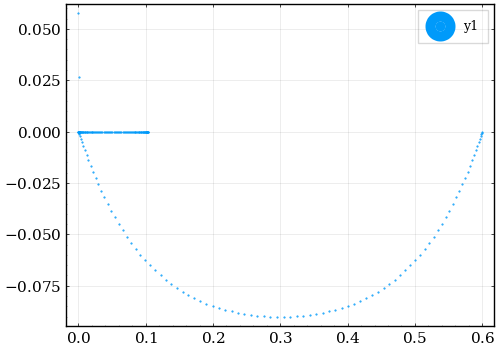

In [10]:
scatter(real.(qi[1:end]),imag.(qi[1:end]),markersize=0.5)

In [11]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [12]:
function VMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,plist=qi,isπ=true,des=Vmat)
    getqw(E,Λ)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [13]:
VMat!(3.875)

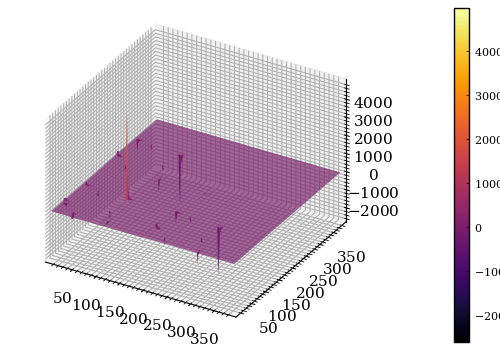

In [14]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

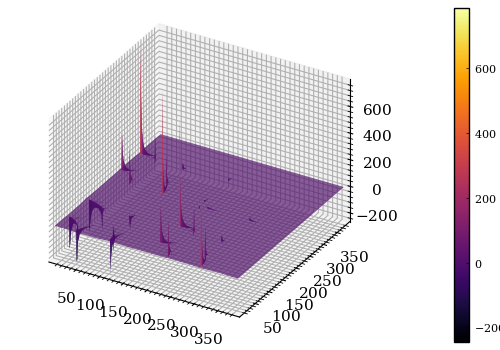

In [15]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [14]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [15]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gc(E,qi[2+len+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gn(E,qi[2+len+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [16]:
function detVG(E;Λ=0.5,a = 0.0,a1=0.0,I=0)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [17]:
function TMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,des=Tmat)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [18]:
@btime TMat!(3.875)

  77.047 ms (4672 allocations: 9.68 MiB)


In [21]:
let 
    function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
        TMat!(E;Λ=x[1],I=I,a1=1.0)
        return 1/abs(Tmat[1,1])
    end
    
    tmpf(x)=inv_abst(x)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.2]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00020106603511810118
[0.593439497827106]


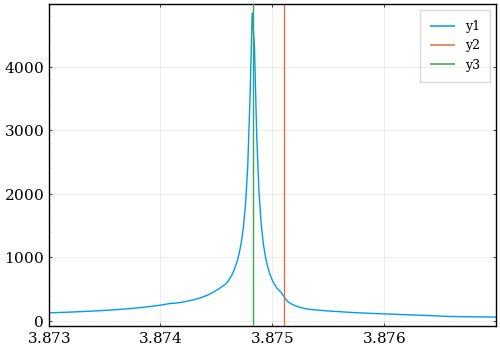

In [22]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.593439497827106,a1=1.0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

# Extract pole position

In [19]:
function find_poles(pars)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, -24e-6])
#     (tmp.zero[1]-mDn-mDsc)+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

In [24]:
find_poles([0.593439497827106,1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, -2.4e-5]
 * Zero: [3.874826689413711, -2.4615278771805838e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

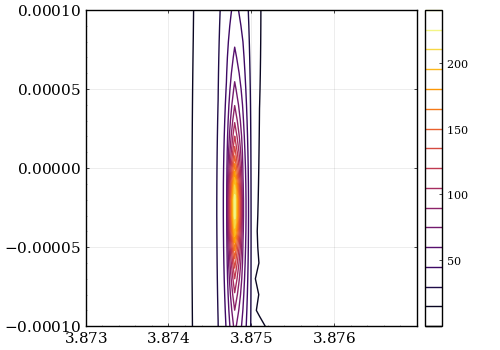

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [25]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.593439497827106,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=false)
end

# Fitting

In [20]:
using Interpolations;

In [21]:
function maketmatrixf(E)
    tmatrix=zeros(ComplexF64,len)
    tmp=zero(ComplexF64)
    for k in 3:(2+len)
        tmp=1.0
        for i in eachindex(wi)
            tmp+=wi[i]*qi[2+len+i]^2*Gc(E,qi[2+len+i])*Tmat[k,2+len+i]
            tmp+=-wi[i]*qi[2+len+i]^2*Gn(E,qi[2+len+i])*Tmat[k,sublen+2+len+i]
        end
        tmatrix[k-2]=tmp
    end
    return LinearInterpolation(real.(qi[3:2+len]),tmatrix)
end

maketmatrixf (generic function with 1 method)

In [22]:
function Γ3f(E;Λ = 0.5,a1=1.0)
     TMat!(E;Λ = Λ,a1=a1)

    res = 0.0
    μ1, μ2 = μf(mDn, mDsc), μf(mDc, mDsn)
    m1,m2,m3=mDn,mπc,mDn

    tmptmatrixf = maketmatrixf(E)
    tmatrixf(p) = (real(qi[3]) <= p && p <= real(qi[2+len])) ? tmptmatrixf(p) : 0.0
    for i in eachindex(xxx)
        for j in eachindex(xxx)
            x1, x2, w1, w2 = xxx[i], xxx[j], www[i], www[j]
            s23=(m2+m3)^2*(1-x1)+(E-m1)^2*x1
            s12_min=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)-sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12_max=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)+sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12=s12_min*(1-x2)+s12_max*x2
            q,qbar=sqrt(λf(s23,mπc^2,mDn^2))/(2*sqrt(s23)),sqrt(λf(s12,mDn^2,mπc^2))/(2*sqrt(s12))
            p,pbar=sqrt(λf(E^2,mDn^2,s23))/(2*E),sqrt(λf(E^2,mDn^2,s12))/(2*E)
            res+=w1*w2*abs((E-m1)^2-(m2+m3)^2)*abs(s12_max-s12_min)*abs(q*tmatrixf(p)*Gc(E,p)+qbar*tmatrixf(pbar)*Gc(E,pbar))^2
        end
    end
    return res
end

Γ3f (generic function with 1 method)

In [23]:
function Resolution(E, E1)
    σ1 = 1.05 * 263e-6
    σ2 = 2.413 * σ1
    α = 0.778
    gaussfunc(x, μ, σ) = 1 / sqrt(2 * π) / σ * exp(-(x - μ)^2 / (2 * σ^2))
    return α * gaussfunc(E, E1, σ1) + (1 - α) * gaussfunc(E, E1, σ2)
end

Resolution (generic function with 1 method)

## fitting

In [24]:
using PyCall;
import NLsolve;
piminuit=pyimport("iminuit");

In [25]:
let 
    data_ddπ_sub_df = DataFrame(CSV.File("./data/ddpi_sub_du.csv", header = ["x", "y"]));
    len=length(data_ddπ_sub_df.x)
    len1=Int64(len/3)
    xv=[3.8731+0.0002*(i-1) for i in 1:20]
    yv=[data_ddπ_sub_df.y[3*(i-1)+2] for i in 1:len1]
    wv=[abs(data_ddπ_sub_df.y[3*(i-1)+1]-data_ddπ_sub_df.y[3*(i-1)+3])/2 for i in 1:len1]
    global const data_ddπ_sub=Data(xv,yv,wv);
    nothing
end

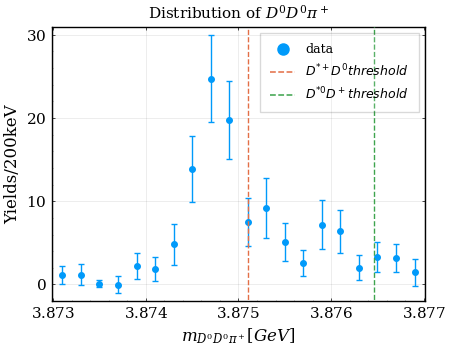

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.6056031611752245, 0.9786801175696073, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [26]:
@plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = "Yields/200keV" label = "data" size = (450, 350)
vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")

In [27]:
mutable struct distr
    Λ::Float64
    a1::Float64
    Γ3::Vector{Float64}
end

In [28]:
let Λ = 0.593439497827106,a1=1.0,Ev = range(3.873, 3.877, 100)
    resv = [Γ3f(e; Λ = Λ,a1=a1) for e in Ev]
    global distr_inst = distr(Λ,a1, resv)
end

distr(0.593439497827106, 1.0, [0.0074905401322940155, 0.00814680997374398, 0.008867906699612545, 0.00966231024614113, 0.010538132547946538, 0.011503904245740194, 0.012571923644475198, 0.013753713270891697, 0.015067913051497931, 0.016527569664802337  …  1.4631578072374616, 1.4699364056988322, 1.5770600886515591, 1.395521760823601, 1.347889288368541, 1.5031718077992435, 1.3791722644631286, 1.2516477597578215, 1.3840007405085517, 1.4090722461440246])

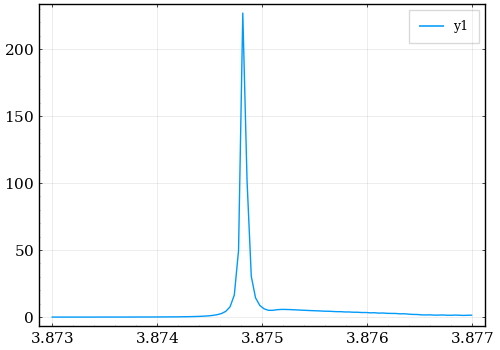

In [37]:
plot(range(3.873, 3.877, 100),distr_inst.Γ3)

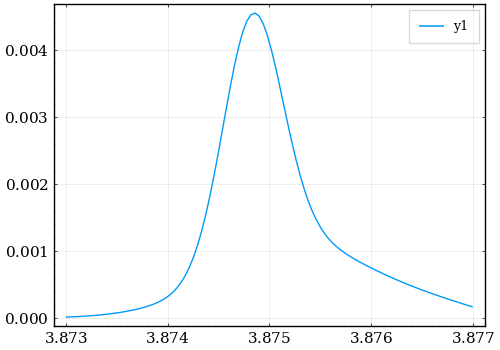

In [39]:
let
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, distr_inst.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xxx, www)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x 
    tmpf1(E)=quadgauss(x->ΔE*tmpf(Ebin(E,x)),xxx,www)
    plot(Ev,tmpf1.(Ev))
end

In [29]:
function remake_distr(dis::distr, Λ,a1)
    if Λ ≈ dis.Λ&&a1≈dis.a1
        return false
    else
        Ev = range(3.873, 3.877, 100)
        for i in eachindex(dis.Γ3)
            dis.Γ3[i] = Γ3f(Ev[i];Λ = Λ,a1=a1)
        end
        dis.Λ = Λ
        dis.a1=a1
    end
    return true
end

remake_distr (generic function with 1 method)

In [30]:
function dist(E, pars; dis = distr_inst, xx = xxx, ww = www)
    N, Λ,a1 = pars
    remake_distr(dis, Λ,a1)
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, dis.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xx, ww)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x
    return N * quadgauss(x->ΔE*tmpf(Ebin(E,x)),xx,ww)
end

dist (generic function with 1 method)

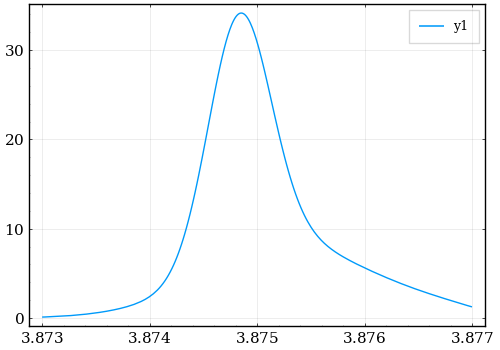

In [42]:
plot(e->dist(e,[1,0.593439497827106,1.0])*30/0.004,3.873,3.877)

In [43]:
fcn(x,y,z; fitrange = ()) = chisq(dist, data_ddπ_sub,[x,y,z]; fitrange = fitrange)

fcn (generic function with 1 method)

## fitting results

### fix a1=1.0

In [47]:
let 
    _n,_lam,_a1=[5000,0.593439497827106,1.0]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,a1=_a1,name=("N","lam","a1"))
    set!(tmp_model.limits,"N",(2000,8000))
    set!(tmp_model.limits,"lam",(0.3,1.2))
    set!(tmp_model.fixed,"a1",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=6.648527264592899e-06 edm_goal=0.0002 errordef=1.0 fval=16.095288132928875 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=83 ngrad=0 reduced_chi2=nan time=725.7569800420001>
(Param(number=0, name='N', value=3747.8795562564933, error=665.9511208973936, merror=None, is_const=False, is_fixed=False, lower_limit=2000.0, upper_limit=8000.0), Param(number=1, name='lam', value=0.5954897610260301, error=0.0008884295502599726, merror=None, is_const=False, is_fixed=False, lower_limit=0.3, upper_limit=1.2), Param(number=2, name='a1', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[ 4.52604149e+05 -4.79638133e-01  0.00000000e+00]
 [-4.79638133e-01  7.89308228e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

In [48]:
print(fitres.values)

PyObject <ValueView N=3747.8795562564933 lam=0.5954897610260301 a1=1.0>

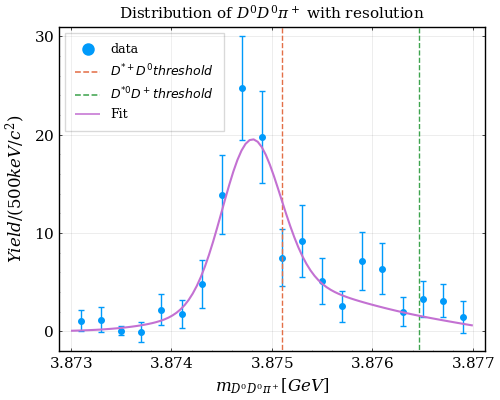

In [49]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [3747.8795562564933,0.5954897610260301,1.0]), lw = 1.5, label = "Fit")
end

In [50]:
find_poles([0.5954897610260301,1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, -2.4e-5]
 * Zero: [3.874791887341594, -2.4115719928873276e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [51]:
3.874791887341594-mDn-mDsc

-0.00030811265840613444

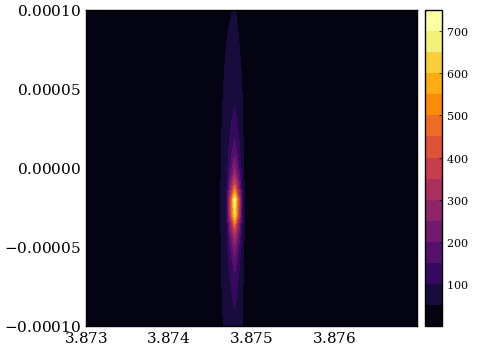

In [63]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.5954897610260301,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

In [61]:
16.1/(20-1)

0.8473684210526317

### a1 not fixed

In [56]:
let 
    _n,_lam,_a1=[3747.8795562564933,0.5954897610260301,0.99]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,a1=_a1,name=("N","lam","a1"))
    set!(tmp_model.limits,"N",(3000,5000))
    set!(tmp_model.limits,"lam",(0.5,0.7))
    set!(tmp_model.limits,"a1",(0.9,1.0))
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=5.902808995016548e-06 edm_goal=0.0002 errordef=1.0 fval=14.914251573298655 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=292 ngrad=0 reduced_chi2=nan time=3126.8861325000007>
(Param(number=0, name='N', value=4085.0697384800314, error=436.27858289868163, merror=None, is_const=False, is_fixed=False, lower_limit=3000.0, upper_limit=5000.0), Param(number=1, name='lam', value=0.6086306009844105, error=0.00026725748272599104, merror=None, is_const=False, is_fixed=False, lower_limit=0.5, upper_limit=0.7), Param(number=2, name='a1', value=0.971352722443013, error=0.0027448005592254354, merror=None, is_const=False, is_fixed=False, lower_limit=0.9, upper_limit=1.0))
[[ 2.03924993e+05 -9.28443048e-04  3.28433929e-01]
 [-9.28443048e-04  7.14267334e-08 -1.83272633e-07]
 [ 3.28433929e-01 -1.83272633e-07  7.54320445e-06]]

In [57]:
print(fitres.values)

PyObject <ValueView N=4085.0697384800314 lam=0.6086306009844105 a1=0.971352722443013>

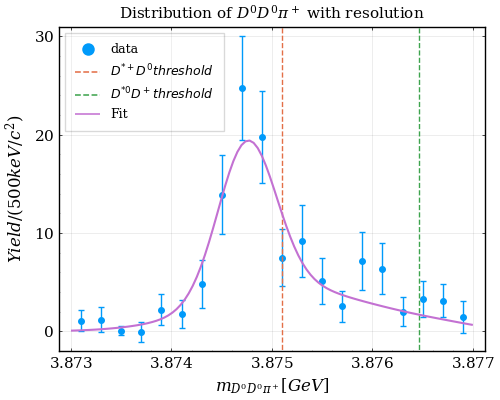

In [58]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [4085.0697384800314,0.6086306009844105,0.971352722443013]), lw = 1.5, label = "Fit")
end

In [59]:
find_poles([0.6086306009844105,0.971352722443013])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, -2.4e-5]
 * Zero: [3.8747498005343224, -2.34995062694705e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [60]:
3.8747498005343224-mDn-mDsc

-0.0003501994656778251

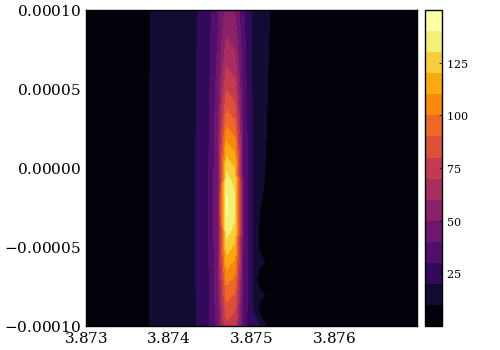

In [64]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.6086306009844105,a1=0.971352722443013)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

In [62]:
14.91/(20-2)

0.8283333333333334

# Get data

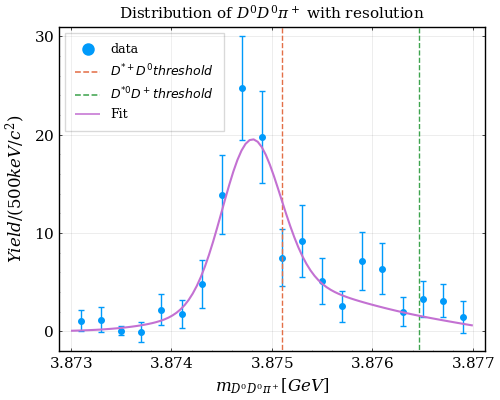

In [31]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [3747.8795562564933,0.5954897610260301,1.0]), lw = 1.5, label = "Fit")
end

In [32]:
let Ev = range(3.873, 3.877, 100)
    yields=[dist(e, [3747.8795562564933,0.5954897610260301,1.0]) for e in Ev]
    df=DataFrame(X=Ev,Y=yields)
    CSV.write("./output/fit3_1.csv",df)
end

"./output/fit3_1.csv"

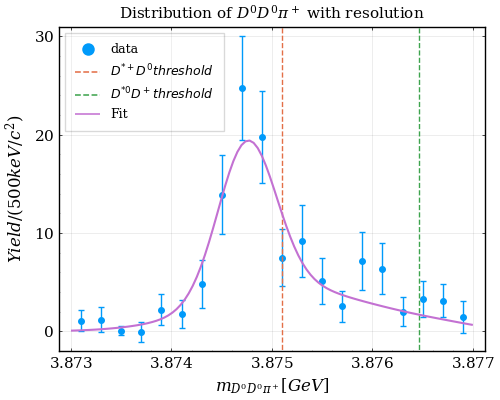

In [33]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [4085.0697384800314,0.6086306009844105,0.971352722443013]), lw = 1.5, label = "Fit")
end

In [34]:
let Ev = range(3.873, 3.877, 100)
    yields=[dist(e, [4085.0697384800314,0.6086306009844105,0.971352722443013]) for e in Ev]
    df=DataFrame(X=Ev,Y=yields)
    CSV.write("./output/fit3_2.csv",df)
end

"./output/fit3_2.csv"

In [44]:
pyplot()

Plots.PyPlotBackend()

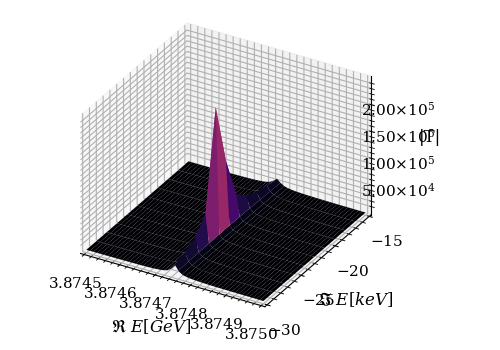

In [45]:
let Ev=collect(3.8745:10e-6:3.875),Γv=collect(-30:1.5:-15)
    function tmpf(E)
        TMat!(E;Λ=0.6086306009844105,a1=0.971352722443013)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e+im*γ*1e-6) for γ in Γv,e in Ev]
    surface(Ev,Γv,resv,legend=false,xlabel=L"\Re\ E[GeV]",ylabel=L"\Im\ E[keV]",zlabel="|T|")
end

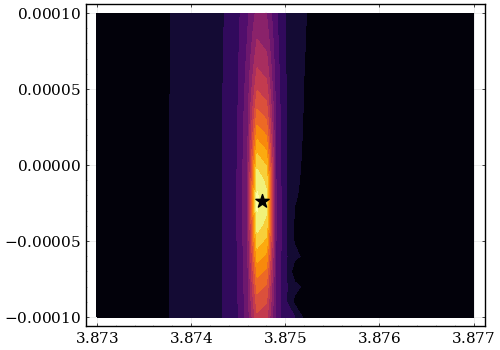

In [49]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    function find_poles(pars)
        _lam,_a1=pars
        function f!(F, x)
            e, γ = x
            tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
            F[1] = real(tmp)
            F[2] = imag(tmp)
        end
        tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, -24e-6])
        tmp.zero[1]+im*tmp.zero[2]
    end
    
    resv=[1/abs(detVG(e+im*γ;Λ=0.6086306009844105,a1=0.971352722443013)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true,legend=false)
    tmp=find_poles([0.6086306009844105,0.971352722443013])
    scatter!([real(tmp)],[imag(tmp)],markershape=:star5,markersize=10,color=:black)
end

# ERE

In [50]:
function find_poles(pars)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, -24e-6])
    tmp.zero[1]+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

In [51]:
find_poles([0.6086306009844105,0.971352722443013])

3.8747498005343224 - 2.34995062694705e-5im

In [52]:
TMat!(3.8747498005343224 - 2.34995062694705e-5im;Λ=0.6086306009844105,a1=0.971352722443013)

In [53]:
Tmat[1,1]

-4.8449469353098315e11 - 1.2720604456424701e11im

In [54]:
qon_c(3.8747498005343224 - 2.34995062694705e-5im)

0.0007273971993888197 + 0.026022852376386397im

In [55]:
let 
    kr,ki=reim(qon_c(3.8747498005343224 - 2.34995062694705e-5im))
    a=-2*ki/(kr^2+ki^2)
    r=-1/ki
    println(a)
    println(r)
end

-76.79552321380615
-38.42776285767266


In [56]:
1/sqrt(1+2*abs(38.42776285767266/-76.79552321380615))

0.7069687010399952

In [57]:
Gc(3.8747498005343224 - 2.34995062694705e-5im,0)

-144.4715616670341 - 6.516661061157701im

In [58]:
let 
    function f!(F, x)
        e, γ = x
        tmp = Gc(e+im*γ,0)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    NLsolve.nlsolve((F, x) -> f!(F, x), [3.8747498005343224, - 2.34995062694705e-5])
end

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747498005343224, -2.34995062694705e-5]
 * Zero: [-141127.66141425402, 88219.55016272955]
 * Inf-norm of residuals: 0.000000
 * Iterations: 33
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 34
 * Jacobian Calls (df/dx): 34